# 20152410 배형준 머신러닝 과제9

In [1]:
# library import

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# set my local working directory

import os

directory = 'C:\\Users\\golds\\Desktop\\중앙대학교\\2020-1 4학년 1학기\\머신러닝'
os.chdir(directory)

In [3]:
# load dataset

filename = './과제9/mnist.csv'
mnist = pd.read_csv(filename, header=None)
mnist.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# convert data type from pd.DataFrame to np.array

label = np.array(mnist.iloc[:, 0]).reshape(-1, 1)
data = np.array(mnist.iloc[:, 1:])

## Implement Normalization class

행 방향으로 정규화 : 한 행에서 (하나의 숫자 그림에서) 가장 작은 값이 0, 가장 큰 값이 1이 되도록 변환

In [5]:
# make class 'minmaxscaler'

class minmaxscaler:
    
    def __init__(self):
        self.min_value = 0
        self.max_value = 0
        
    def fit(self, X):
        X = np.array(X)
        self.min_value = np.min(X, axis=1)
        self.max_value = np.where(np.max(X, axis=1) == 0, 1, np.max(X, axis=1))
        # 행 별 최대 최소, 열 방향으로
        
        return self
    
    def transform(self, X):
        X = np.array(X)
        scaled = np.zeros(X.shape)
        
        for j in range(X.shape[0]):
            scaled[j, :] = (X[j, :] - self.min_value[j]) / (self.max_value[j] - self.min_value[j])
        
        return scaled

In [6]:
minmax_scaler_model = minmaxscaler()
minmax_scaler_model.fit(data)
data_scaled = minmax_scaler_model.transform(data)

## Implement Onehot encoding class

In [7]:
class onehotencoding:
    
    def __init__(self):
        self.unique = 0
    
    def fit(self, X):
        X = np.array(X)
        self.unique = np.unique(X)
        
        return self
    
    def transform(self, X):
        X = np.array(X)
        m = X.shape[0]
        n = self.unique.shape[0]
    
        empty = np.zeros((m, n))
        
        for i in range(m):
            for j in range(n):
                if X[i] == self.unique[j]:
                    empty[i, j] = 1
        
        return empty

In [8]:
onehot_model = onehotencoding()
onehot_model.fit(label)
label_onehot = onehot_model.transform(label)

## Split trainset and testset

In [9]:
train_index = 6000

train_label = label[:train_index]
test_label = label[train_index:]

label_onehot_train = label_onehot[:train_index, :]
label_onehot_test = label_onehot[train_index:, :]

data_scaled_train = data_scaled[:train_index, :]
data_scaled_test = data_scaled[train_index:, :]

## Implement Neural Network class

In [10]:
class neural_network:

    def __init__(self, learning_rate, error_bound, iteration, random_state,
                 hidden_layer, number_node, fit_intercept):
        self.learning_rate = learning_rate
        self.error_bound = error_bound
        self.iteration = iteration
        self.random_state = random_state
        
        self.hidden_layer = hidden_layer # int
        self.number_node = number_node # list of int
        self.fit_intercept = fit_intercept # True or False
        
        self.record_train_cost = []
        self.record_test_cost = []
        self.record_train_accuracy = []
        self.record_test_accuracy = []
        
        self.coef_list = []
        self.train_predict = []
        self.test_predict = []
        self.last_gradient = []
    
    def sigmoid(self, X, coef):
        z = np.dot(X, coef)
        sigmoid_value = 1 / (1 + np.exp(-z))
        
        return sigmoid_value
    
    def cost(self, X, coef_list, onehot_label):
        delta = 10**(-8)
        m = X.shape[0]
        temp = X
        sigmoid_list = []
        
        # forward propagation
        for coef in coef_list:    
            sig = self.sigmoid(temp, coef)
            sigmoid_list.append(sig)
            
            if self.fit_intercept == True:
                temp = np.column_stack((np.ones((sig.shape[0], 1)), sig))
            else:
                temp = sig
        
        cost_value = -np.mean(np.sum(onehot_label * np.log(sig + delta) + (1 - onehot_label) * np.log(1 - sig + delta), axis=1))
        
        return cost_value, sigmoid_list
    
    def gradient(self, X, coef_list, onehot_label, sigmoid_list):
        m = X.shape[0]
        delta_list = []
        gradient_list = []
        
        add_constant_sigmoid = []
        
        for i in range(len(sigmoid_list)):
            temp = np.column_stack((np.ones((sigmoid_list[i].shape[0], 1)), sigmoid_list[i]))
            add_constant_sigmoid.append(temp)
        
        sigmoid_list.insert(0, X)
        add_constant_sigmoid.insert(0, X)
        
        # backward propagation
        for i in range(self.hidden_layer+1):
            if i == 0:
                delta_value = sigmoid_list[-1] - onehot_label
                gradient_value = np.dot(add_constant_sigmoid[-2].T, delta_value) / m
                
                delta_list.insert(0, delta_value)
                gradient_list.insert(0, gradient_value)
            
            else:
                delta_value = np.dot(delta_list[0], coef_list[-i][1:, :].T) * sigmoid_list[-i-1] * (1 - sigmoid_list[-i-1])
                gradient_value = np.dot(add_constant_sigmoid[-i-2].T, delta_value) / m
                
                delta_list.insert(0, delta_value)
                gradient_list.insert(0, gradient_value)
        
        return gradient_list
    
    def predict(self, sigmoid_list, predict_type='class'):
        output_layer = sigmoid_list[-1]
        
        if predict_type == 'class':
            predict_value = np.argmax(output_layer, axis=1)
        
        elif predict_type == 'response':
            predict_value = output_layer
        
        return predict_value
    
    def fit(self, X_train, Y_train, X_test, Y_test): # Y_train, Y_test는 onehotencoding이 완료된 데이터
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        X_test = np.array(X_test)
        Y_test = np.array(Y_test)
        m = X_train.shape[0]
        n = X_train.shape[1]
        q = X_test.shape[0]
        p = Y_train.shape[1]
        label_train = np.argmax(Y_train, axis=1).reshape(-1, 1) # train accuracy 계산하기 위한 label
        label_test = np.argmax(Y_test, axis=1).reshape(-1, 1) # test accuracy 계산하기 위한 label
        
        self.number_node.insert(0, n)
        self.number_node.append(p)
        coef_list = []
        
        # fit_intercept
        if self.fit_intercept == True:
            number_node_with_intercept = []
            
            X_train = np.column_stack((np.ones((m, 1)), X_train))
            X_test = np.column_stack((np.ones((q, 1)), X_test))
            
            for number in self.number_node:
                number_node_with_intercept.append(number+1)
                
        else:
            number_node_with_intercept = self.number_node
        
        # set initial parameters
        np.random.seed(self.random_state) # for reproducibility
        
        for layer in range(self.hidden_layer+1):
            temp_theta = np.random.randn(number_node_with_intercept[layer], self.number_node[layer+1])
            coef_list.append(temp_theta)
        
        # check model fitting progress
        import time
        start = time.time()
        
        # model fitting
        while True:
            # calculate train and test cost
            train_cost, train_sigmoid = self.cost(X_train, coef_list, Y_train)
            test_cost, test_sigmoid = self.cost(X_test, coef_list, Y_test)
            
            self.record_train_cost.append(train_cost)
            self.record_test_cost.append(test_cost)
            
            # calculate train and test accuracy
            train_predict = self.predict(train_sigmoid, predict_type='class').reshape(-1, 1)
            test_predict = self.predict(test_sigmoid, predict_type='class').reshape(-1, 1)
            
            train_accuarcy = np.mean(train_predict == label_train)
            test_accuarcy = np.mean(test_predict == label_test)
            
            self.record_train_accuracy.append(train_accuarcy)
            self.record_test_accuracy.append(test_accuarcy)
            
            # calculate gradient using back propagation and renew the parameters
            gradient_list = self.gradient(X_train, coef_list, Y_train, train_sigmoid)
            
            for i in range(len(coef_list)):
                coef_list[i] = coef_list[i] - self.learning_rate * gradient_list[i]

            # stopping rules
            length = len(self.record_train_accuracy)
            
            if length > self.iteration:
                if self.record_train_accuracy[-2] - self.record_train_accuracy[-1] < self.error_bound:
                    break
            
            # print model fitting progress
            running_time = time.time() - start
            minute = int(running_time // 60)
            second = round(running_time % 60, 1)
            
            if length % 250 == 0:
                print('Iter : {}, Running time : {}m {}s'.format(length, minute, second), end=', ')
                print('Train accuracy : {}%, Test accuracy : {}%'.format(round(100*train_accuarcy, 2),
                                                                         round(100*test_accuarcy), 2))
                print('Train Cost : {}, Test Cost : {}\n'.format(train_cost, test_cost))
            
            # error situation : too much iteration
            if length > 100000:
                print('반복 횟수가 너무 많습니다. Train Cost가 수렴하지 못했습니다. 학습률을 조정해보시기 바랍니다.')
                break
                
        self.coef_list = coef_list
        self.train_predict = train_predict
        self.test_predict = test_predict
        self.last_gradient = gradient_list
        
        return self

# 0. Optimization

In [11]:
model_neural_network = neural_network(learning_rate=1,
                                      error_bound=10**(-7),
                                      iteration=2000,
                                      random_state=20152410,
                                      hidden_layer=2,
                                      number_node=[196, 49],
                                      fit_intercept=True)

In [12]:
model_neural_network.fit(X_train=data_scaled_train,
                         Y_train=label_onehot_train,
                         X_test=data_scaled_test,
                         Y_test=label_onehot_test)

Iter : 250, Running time : 1m 38.7s, Train accuracy : 86.35%, Test accuracy : 80.0%
Train Cost : 0.9007139534289245, Test Cost : 1.1773309972954054

Iter : 500, Running time : 3m 2.6s, Train accuracy : 93.07%, Test accuracy : 83.0%
Train Cost : 0.5492653650430479, Test Cost : 0.9544216257366072

Iter : 750, Running time : 4m 30.3s, Train accuracy : 95.73%, Test accuracy : 86.0%
Train Cost : 0.3818610319592285, Test Cost : 0.8683450877671531

Iter : 1000, Running time : 5m 57.3s, Train accuracy : 97.1%, Test accuracy : 87.0%
Train Cost : 0.28285662882634954, Test Cost : 0.8304008068730805

Iter : 1250, Running time : 7m 19.3s, Train accuracy : 97.92%, Test accuracy : 87.0%
Train Cost : 0.2170620991036495, Test Cost : 0.810978181054526

Iter : 1500, Running time : 8m 40.8s, Train accuracy : 98.52%, Test accuracy : 88.0%
Train Cost : 0.17194119179674044, Test Cost : 0.8067734671806731

Iter : 1750, Running time : 10m 2.9s, Train accuracy : 98.95%, Test accuracy : 88.0%
Train Cost : 0.1392

## Source of plot of the classification example

In [13]:
number = 10
size_row = 28
size_col = 28

train_cor_index = []
train_mis_index = []

test_cor_index = []
test_mis_index = []

for i in range(len(train_label)):
    if model_neural_network.train_predict[i] == train_label[i]:
        train_cor_index.append(i)
    else:
        train_mis_index.append(i)

for j in range(len(test_label)):
    if model_neural_network.test_predict[j] == test_label[j]:
        test_cor_index.append(j)
    else:
        test_mis_index.append(j)

In [14]:
cor_index = test_cor_index[:number]
cor_label = test_label[cor_index]
cor_pred = model_neural_network.test_predict[cor_index]
cor_data = data_scaled_test[cor_index, :]

mis_index = test_mis_index[:number]
mis_label = test_label[mis_index]
mis_pred = model_neural_network.test_predict[mis_index]
mis_data = data_scaled_test[mis_index, :]

In [15]:
cor_data_list = []
mis_data_list = []

for a in range(number):
    cor_pixel = cor_data[a, :].reshape(size_row, size_col)
    mis_pixel = mis_data[a, :].reshape(size_row, size_col)
    
    cor_data_list.append(cor_pixel)
    mis_data_list.append(mis_pixel)

# 1. Plot the loss curve

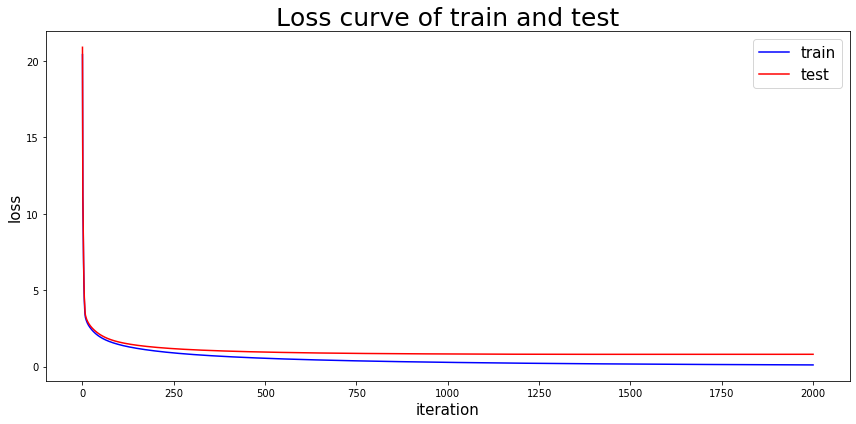

In [16]:
traincost = model_neural_network.record_train_cost
testcost = model_neural_network.record_test_cost

plt.figure(figsize=(12, 6))
plt.plot(traincost, 'b', label='train')
plt.plot(testcost, 'r', label='test')
plt.title('Loss curve of train and test', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

# 2. Plot the accuracy curve

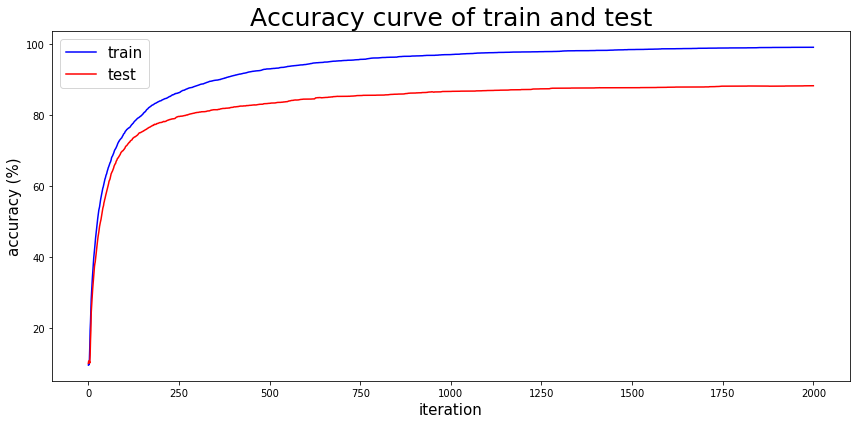

In [17]:
trainacc100 = 100*np.array(model_neural_network.record_train_accuracy)
testacc100 = 100*np.array(model_neural_network.record_test_accuracy)

plt.figure(figsize=(12, 6))
plt.plot(trainacc100, 'b', label='train')
plt.plot(testacc100, 'r', label='test')
plt.title('Accuracy curve of train and test', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('accuracy (%)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

# 3. Plot the accuracy value

In [18]:
traina = round(trainacc100[-1], 2)
testa = round(testacc100[-1], 2)
trainb = traincost[-1]
testb = testcost[-1]

print('Final train accuracy : {}%, Final train loss : {}'.format(traina, trainb))
print('Final test accuracy : {}%, Final test loss : {}'.format(testa, testb))

Final train accuracy : 99.15%, Final train loss : 0.11513519652110232
Final test accuracy : 88.32%, Final test loss : 0.809848869051793


# 4. Plot the classification example

## 4-1 Plot of right-predicted classification caes

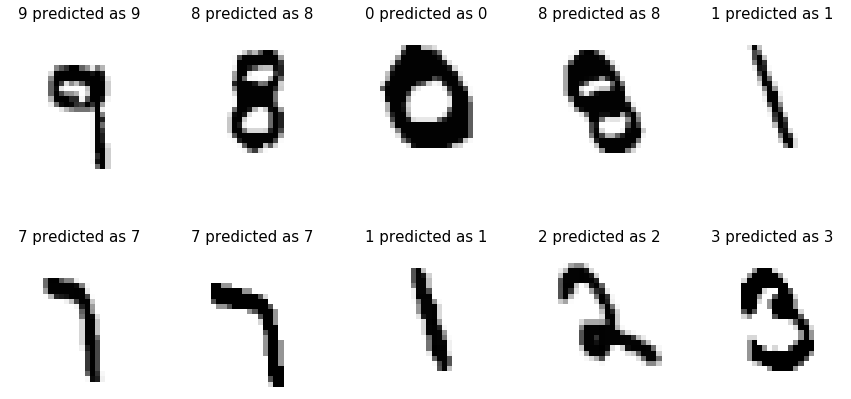

In [19]:
fig1, axes1 = plt.subplots(2, 5, figsize=(15, 7.5))
axes1 = axes1.ravel()

for p in range(number):
    axes1[p].imshow(cor_data_list[p], cmap='Greys', interpolation=None)
    axes1[p].set_title('{} predicted as {}'.format(int(cor_label[p]), int(cor_pred[p])), fontsize=15)
    axes1[p].axis('off')

## 4-2 Plot of mis-predicted classification caes

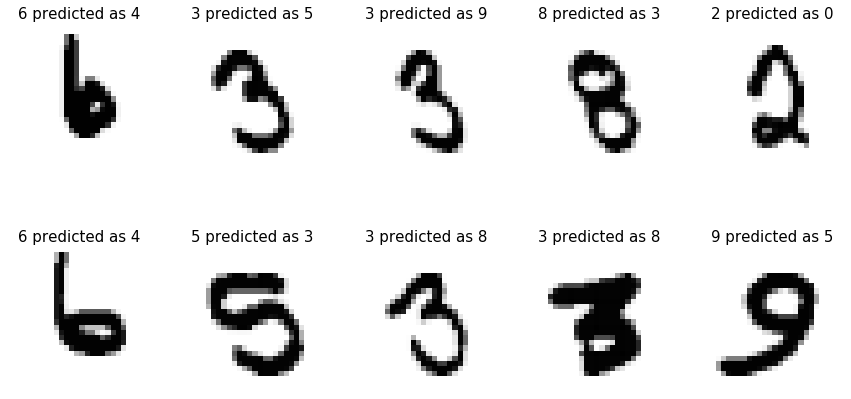

In [20]:
fig2, axes2 = plt.subplots(2, 5, figsize=(15, 7.5))
axes2 = axes2.ravel()

for p in range(number):
    axes2[p].imshow(mis_data_list[p], cmap='Greys', interpolation=None)
    axes2[p].set_title('{} predicted as {}'.format(int(mis_label[p]), int(mis_pred[p])), fontsize=15)
    axes2[p].axis('off')